## Bernoulli Bandits and Thompson Sampling

A very simple case that is useful to look at in order to gain intuition is that of the Beta-Bernoulli Bandit. The Bandit has some number of arms, K, where the underlying probability distributions are Bernoulli. In other words, the agent receives a reward of '1' with probability $\theta_{k}$ and otherwise receives no reward. 

This kind of Bandit is extremely useful to build up an intuition of the Bayesian approach to a Bandit problem: Thompson sampling. Here, the idea is that the agent has a prior belief about the value of $\theta$.

The process of explore-exploit is not $\epsilon$-greedy; now we focus on sampling in such a way as to update the posterior beliefs of $\theta_{k}$ in the most efficient way. Let's dig in to what that means, by first creating a bandit. 

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class BernoulliBandit:
    """Class for a simple k-armed bandit without context dependence, using Bernoulli distributions.
    It includes variable number of arms, initialization reward distribution for
    each arm (hidden from agent) and method to have arm pulled and return reward. """

    def __init__(self, k):
        self.k = k
        self.theta = np.random.uniform(low=0, high = 1, size=k) #this is theta for each arm -- prob of pulling a '1'

        self.best_arm = np.argmax(self.theta)
        
        self.best_reward = 1
        self.expected_reward = self.theta

    def pull_lever(self, lever):
        test_rand = np.random.uniform(low = 0, high = 1)
        if self.theta[lever] > test_rand:
            return 1
        else:
            return 0
        

Let's get a standard agent parent class that we can build on for Thompson sampling, and build a Thompson sampler on top of that. This is just for the case of Bernoulli bandits at the moment

In [84]:
class StandardAgent:
    
    def __init__(self, bandit):
        #only require the bandit to initialise
        
        #general attributes of all agents
        self.bandit = bandit
        self.pull_record = [0] * self.bandit.k
        self.action_sequence = []
        
        #for keeping track of how the agent learns
        self.num_optimal_pulls = 0
        self.optimal_trajectory = []
        
        #estimated Q is the value of each action, or the expected reward of each action
        self.estimatedQ = [0] * self.bandit.k
        
        #keep track of the agent's knowledge of the probability distributions
        #cumulative regret
        self.total_regret = 0
        #keeping an eye on how regret changes
        self.regrets_trajectory = []
        
    def update_R(self, lever):
        
        self.total_regret += (self.bandit.best_reward - self.bandit.expected_reward[lever])
        self.regrets_trajectory.append(self.total_regret)
        
    def choose_lever(self):
        #in child classes this involves getting back the lever and returning the reward
        raise NotImplementedError('Not a method in this parent class.')
        
    @property
    def Q_values(self):
        raise NotImplementedError('Not a method in this parent class.')
        
    def run_trial(self, n_steps):
        for step in range(n_steps):
            
            lever = self.choose_lever()
            
            # Update the array keeping track of how many times each lever has been pulled
            self.pull_record[lever] += 1
            
            # update whether lever was best
            if lever == self.bandit.best_arm:
                self.num_optimal_pulls += 1
            self.optimal_trajectory.append(self.num_optimal_pulls / np.sum(self.pull_record))
            
            self.action_sequence.append(lever)
            # update the regret 
            self.update_R(lever)
    

In [223]:
class BernoulliThompsonAgent(StandardAgent):
    def __init__(self, bandit, a_start=1, b_start=1):
        super(BernoulliThompsonAgent, self).__init__(bandit)
        
        self.a = [a_start] * self.bandit.k
        self.b = [b_start] * self.bandit.k
        
        self.theta_estimate = [0]*self.bandit.k
        self.Q_trajectory = [[] for i in range(self.bandit.k)]
        
        print(self.Q_trajectory)
        
    def choose_lever(self):
        
        #using beta prior with initial uniform distribution in first pass
        for i in range(0, self.bandit.k):
            self.theta_estimate[i] = np.random.beta(self.a[i], self.b[i])
        
        #choose the largest resulting theta estimate
        lever = np.argmax(self.theta_estimate)
        reward = self.bandit.pull_lever(lever)
        
        #update the posterior distribution over theta (update parameters of that dist)
        self.a[lever] += reward
        self.b[lever] += 1-reward
        
        self.update_Q()
        
        return lever
    
    def update_Q(self):
        #update the Q values
        for k in range(0, self.bandit.k):
            self.estimatedQ[k] = self.a[k]/(self.a[k] + self.b[k]) #estimate of the Q values for each lever, here they are expectation values
            #print(self.Q_trajectory[k])
            self.Q_trajectory[k].append(self.estimatedQ[k])
    
        
    #record the reward as an update to the 'Q value' for this action:
    @property
    def Q_values(self):
        return self.estimatedQ
        

In [224]:
bandit = BernoulliBandit(10)
t = BernoulliThompsonAgent(bandit)

[[], [], [], [], [], [], [], [], [], []]


In [225]:
t.run_trial(100000)

In [226]:
t.bandit.best_arm

7

In [227]:
t.pull_record

[2, 12, 1, 2, 7, 2, 67, 99866, 9, 32]

In [228]:
t.Q_values

[0.25,
 0.7857142857142857,
 0.3333333333333333,
 0.25,
 0.6666666666666666,
 0.25,
 0.9420289855072463,
 0.9982076340769817,
 0.7272727272727273,
 0.9117647058823529]

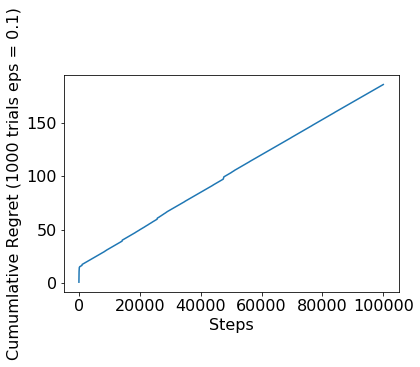

In [229]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

In [230]:
t.bandit.expected_reward

array([0.20075883, 0.9056029 , 0.35306611, 0.1242545 , 0.18934654,
       0.09237537, 0.94308772, 0.99837154, 0.60339621, 0.90186004])

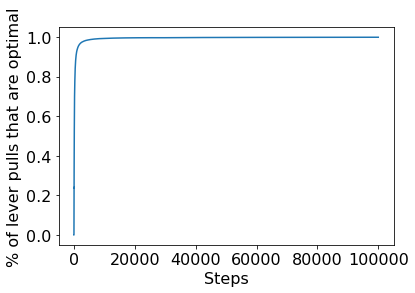

In [231]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

In the interests of demonstrating how this works, let's plot the agent's knowledge of the distributions as the sampling proceeds, as well as the true distributions. 

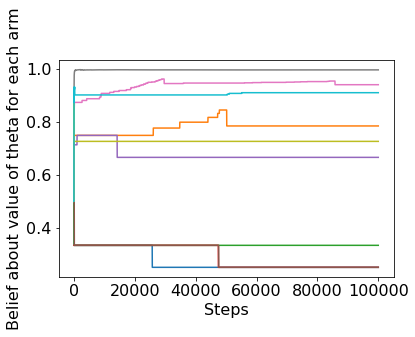

In [236]:
fig, ax = plt.subplots(figsize=(6,4))
for k in range(0,t.bandit.k):
    ax.plot(t.Q_trajectory[k])
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Belief about value of theta for each arm', fontsize=16)
plt.show()

In [234]:
#t.Q_trajectory[0]

In [238]:
t.bandit.theta

array([0.20075883, 0.9056029 , 0.35306611, 0.1242545 , 0.18934654,
       0.09237537, 0.94308772, 0.99837154, 0.60339621, 0.90186004])

In [240]:
[t.Q_trajectory[p][-1] for p in range(t.bandit.k)]

[0.25,
 0.7857142857142857,
 0.3333333333333333,
 0.25,
 0.6666666666666666,
 0.25,
 0.9420289855072463,
 0.9982076340769817,
 0.7272727272727273,
 0.9117647058823529]

In [246]:
best_estimate_arm = np.amin(t.bandit.theta - [t.Q_trajectory[p][-1] for p in range(t.bandit.k)])

In [245]:
t.bandit.theta - [t.Q_trajectory[p][-1] for p in range(t.bandit.k)]

array([-4.92411693e-02,  1.19888612e-01,  1.97327790e-02, -1.25745503e-01,
       -4.77320122e-01, -1.57624631e-01,  1.05873141e-03,  1.63905990e-04,
       -1.23876521e-01, -9.90466588e-03])

This has achieved what we would expect: the error between our expected value of $\theta$ and the true value is most reduced for the arm with the highest payout, as this has been the arm that has been sampled the most times (according to the pull record).

We should also consider a more general case/other cases for Thompson sampling -- for instance, what happens when we are dealing with non-Bernoulli distributions?